# Sufficiency

### Imports

In [1]:
import pandas as pd
import numpy as np
import random

import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib import patches as mpatches
from mpl_toolkits.basemap import Basemap

import seaborn as sns

import os, sys

import sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import pickle

from mpl_toolkits.basemap import Basemap

### Set constants

In [2]:
# Value to change to get correct paths
data_path = 'data/'

In [3]:
inputs_path = data_path + 'inputs/'
intermediate_path = data_path + 'intermediate/'
output_path = data_path + 'outputs/with_irrig/'

base_path = inputs_path + 'Base/'
diet_path = inputs_path + 'diet/'
pop_path = inputs_path + 'population/'

data_2000_no_irrig_path = intermediate_path + 'Baseline_df_iterations/'
data_2000_path = intermediate_path + 'Baseline_df_iterations/with_irrig/'

#data_2050_no_irrig_path = intermediate_path + 'Future_dfs/All_change/'
data_2050_path = intermediate_path + 'Future_dfs/All_change+irrig/'

data_2050_gdp_cont_path = data_2050_path + 'gdp_cont/original/'
data_2050_gdp_income_path = data_2050_path + 'gdp_cat_income/original/'
data_2050_gdp_stat_path = data_2050_path + 'gdp_cat_stat/original/'

data_2050_gdp_cont_clustered_path = data_2050_path + 'gdp_cont/clustered/'
data_2050_gdp_income_clustered_path = data_2050_path + 'gdp_cat_income/clustered/'
data_2050_gdp_stat_clustered_path = data_2050_path + 'gdp_cat_stat/clustered/'

model_output_path = output_path + 'model_output/'
composite_path = output_path + 'composite/'
compare_path = output_path + 'compare/'
suff_path = output_path + 'sufficiency/'


figure_path = 'figures/with_irrig/'
dist_figures_path = figure_path + 'distributions/'
agg_assumption_fig_path = figure_path + 'agg_assumption/'
cluster_fig_path = figure_path + 'clusters/'
convex_hull_fig_path = figure_path + 'convex_hull/'
suff_fig_path = figure_path + 'sufficiency/'
model_fig_path = figure_path + 'models/'
sensitivity_fig_path = figure_path + 'sensitivity/'

model_path = data_path + 'models/'

In [4]:
files_2050 = os.listdir(data_2050_gdp_cont_path)
files_2050 = [filename for filename in files_2050 if 'ssp' in filename]

climate_models, climate_scenarios = [], []

for file in files_2050:
    if len(file) == 11:
        climate_models.append(file[:2])
        climate_scenarios.append(file[3:7])

climate_models = list(set(climate_models))
climate_models.sort()
climate_scenarios = list(set(climate_scenarios))
climate_scenarios.sort()
climate_models, climate_scenarios

(['cc', 'gs', 'he', 'mr'], ['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5'])

## Country sufficiency

### Compute

In [5]:
caloric_req = 2320*1e3*365.25

In [6]:
# Population 
def get_total_pop(ssp):
    '''ssp: 2000 or ssp'''
    pop_dir = inputs_path + 'population/'
    pop = pd.read_csv(os.path.join(pop_dir, 'pop_' + ssp + '.csv'))
    pop = pop.set_index('pixel_id')
    pop_tot = pop['gpw_population'].sum()
    return pop_tot

In [7]:
def get_total_prod(ssp):
    '''ssp: 2000 or ssp'''
    results_dir = compare_path
    if ssp == '2000':
        rez = pd.read_csv(os.path.join(results_dir, 'ssp1_compare.csv')) 
        return rez['calories_2000'].sum()
    else:
        rez = pd.read_csv(os.path.join(results_dir, ssp + '_compare.csv'))
        rez = rez.set_index('pixel_id')
        return rez['calories_2050'].sum()

In [8]:
def calc_CalSuff(prod_available, LS, pop,
            caloric_req = (2320*1e3*365.25) #in cal/capita/yr
           ):
    ''' prod_available (for Food not Feed + accounting for losses) - in Calories
        LS : animal calories availables
        pop : in capita
        caloric_req : default values is ADER=2320 kcal/cap/d (without fish)
        
        This is all per year
    '''
    return (prod_available + LS) / (caloric_req * pop)

#### 2000

In [9]:
pctLS_2000 = .19
LS_2000 = 1.1483e15*1e3 #calories
pct_Prod_Food_2000 = .52

pop_2000 = get_total_pop('2000')
prod_2000 = get_total_prod('2000') # calories

In [10]:
prod_available = prod_2000*pct_Prod_Food_2000

global_CalSuff_2000 = calc_CalSuff(prod_available,
                       LS_2000,
                       pop_2000)

global_CalSuff_2000

1.9568954103348346

#### 2050

In [11]:
feed_conversion_factor = 2.3

# Data source: Bodirsky : share of calories in diet from animal products
pctLS_2050 = .19 #Assuming cst

In [12]:
def global_CalSuff_2050(ssp,
                        pctLS_2050 = .19):
    
    prod_2050 = get_total_prod(ssp)
    
    LS_2050 = pctLS_2050 * (prod_2050*pct_Prod_Food_2000 + feed_conversion_factor*LS_2000) / (1 + pctLS_2050*(feed_conversion_factor-1)) 

    feed_now_food = feed_conversion_factor * (LS_2000-LS_2050)
    
    prod_available = prod_2050*pct_Prod_Food_2000 + feed_now_food
    
    pop = get_total_pop(ssp)

    calsuff = calc_CalSuff(prod_available,
                           LS_2050,
                           pop)
    
    return calsuff

In [13]:
global_CalSuff_2000

1.9568954103348346

In [14]:
for ssp in climate_scenarios:
    print(ssp, global_CalSuff_2050(ssp))

ssp1 1.5112323887526444
ssp2 1.5501459287019408
ssp3 1.2827715529529145
ssp4 1.4490819281406666
ssp5 1.5758471267364784


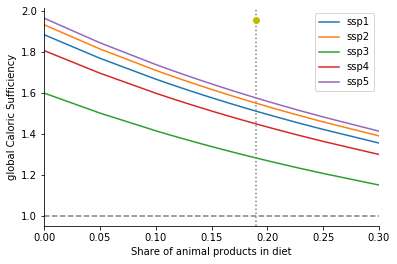

In [15]:
CalSuff_df = pd.DataFrame(columns=['ssp','global_CalSuff','pctLS'])

for ssp in climate_scenarios:
    for pctLS_2050 in [0,.05,.1,.11,.12,.13,.14,.15,.16,.17,.18,.19,.20,.21,.22,.23,.25,.30]:
        
        CalSuff = global_CalSuff_2050(ssp,
                                     pctLS_2050)

        CalSuff_df = CalSuff_df.append({'ssp':ssp,'global_CalSuff':CalSuff,'pctLS':pctLS_2050},ignore_index=True)

fig, ax = plt.subplots()

for ssp, grp in CalSuff_df.groupby(['ssp']):
    ax = grp.plot(ax=ax, kind='line', x='pctLS', y='global_CalSuff', label=ssp)

plt.axvline(x=.19,linestyle=':',color='grey')
plt.axhline(y=1,linestyle='--',color='grey')

# Baseline
plt.plot(.19, global_CalSuff_2000, 'yo') 

#Prettify
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('global Caloric Sufficiency');
plt.xlabel('Share of animal products in diet');
plt.legend(loc='best');

#### By country 2000

In [16]:
countries = pd.read_csv(base_path + 'country_ids.csv')
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1')
countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name', 'sovereignt']],right_on='base_id',left_on='country_id',how='right')
countries = countries.set_index('pixel_id')

In [17]:
countries.head()

,country_id,base_id,ISO3,name,sovereignt
pixel_id,,,,,
330087.0,91.0,91,GRL,Greenland,Denmark
330088.0,91.0,91,GRL,Greenland,Denmark
330089.0,91.0,91,GRL,Greenland,Denmark
330090.0,91.0,91,GRL,Greenland,Denmark
334378.0,91.0,91,GRL,Greenland,Denmark


In [18]:
diet_2000 = pd.read_csv(diet_path + 'Consumption_2000_FAOSTAT.csv')

In [19]:
# LS 2000 Data
LS_2000_df = diet_2000[diet_2000['Item']=='Animal Products'][['Country','Value']].merge(countries[['name','ISO3']].drop_duplicates(),
                                                                                        right_on='name',left_on='Country',how='left')
# kcal/capita/day to cal/capita
LS_2000_df['LS2000_percapita'] = LS_2000_df['Value'].apply(lambda x:x*1e3*365.25)



LS_2000_df = LS_2000_df[['name','ISO3','LS2000_percapita']].set_index('ISO3')

In [20]:
# Population by country
pop_dir = pop_path
pop = pd.read_csv(os.path.join(pop_dir,'pop_2000.csv'))
pop = pop.merge(countries, right_on='pixel_id', left_on='pixel_id')
pop_bycountry_2000 = pop.groupby('ISO3')['gpw_population'].sum()
total_pop_2000 = pop['gpw_population'].sum()

# Production by country
prod = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
prod_bycountry = prod.groupby('ISO3')['calories_2000'].sum()

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [23]:
countries_list = pop_bycountry_2000[pop_bycountry_2000>0].index

In [24]:
len(countries_list)

229

In [25]:
calsuff_numerator = 0
pct_Prod_Food_2000 = .52

for country in countries_list:
    # Production
    prod_country = prod_bycountry[country]
            
    # LS 2000
    try:
        LS2000 = LS_2000_df.at[country,'LS2000_percapita'] * pop_bycountry_2000[country]
    except KeyError:
        try:
            sovereignt_country = countries[countries['ISO3'] == country].drop_duplicates()['sovereignt']
            sovereignt_iso = countries[countries['sovereignt'] == sovereignt_country].drop_duplicates()['ISO3']
            print(country, sovereignt_iso)
            LS2000 = LS_2000_df.at[sovereignt_c,'LS2000_percapita'] * pop_bycountry_2000[sovereignt_c]
        except:
            # Calculate value from total consumption
            LS2000 = LS_2000 / total_pop_2000 * pop_bycountry_2000[country]
        
    # Sufficiency country
    
    
    # Caloric sufficiency's numerator
    calsuff_numerator += ((prod_country * pct_Prod_Food_2000)+LS2000)
    

global_calsuff_2000 = calsuff_numerator/(caloric_req*pop['gpw_population'].sum())
global_calsuff_2000

1.9273473022544423

In [26]:
# Take only countries where we know the production information

sufficiencies = pd.DataFrame()

df = pd.concat([prod_bycountry, pop_bycountry_2000], axis=1)
df = df[df['calories_2000'] > 0]
suff_country = df.apply(lambda r: calc_CalSuff(r['calories_2000']*pct_Prod_Food_2000, LS2000, r['gpw_population']), axis=1).replace([np.inf, -np.inf], np.nan)

sufficiencies['2000'] = suff_country
sufficiencies.loc[df[df['calories_2000'] <= 0].index, '2000'] = np.nan

sufficiencies.head()

,2000
ISO3,
AFG,0.712556
AGO,0.591377
ALB,2.329763
ARE,0.417912
ARG,7.931488


In [27]:
len(sufficiencies)

168

#### By country 2050

In [28]:
def calc_CalSuff_numerator_2050(LS_2000,
                      pct_LS_2050,
                      prod_2050):
    
    LS_2050 = pctLS_2050 * (prod_2050*pct_Prod_Food_2000 + feed_conversion_factor*LS_2000) / (1 + pct_LS_2050*(feed_conversion_factor-1)) 

    feed_now_food = feed_conversion_factor * (LS_2000-LS_2050)
    
    prod_available = prod_2050*pct_Prod_Food_2000 + feed_now_food
    
    return (prod_available+LS_2050)

In [29]:
# Load diets data
diets = pd.read_csv(diet_path + 'pctLS_SSPs_Bodirsky.csv',sep=';')

for ssp in climate_scenarios:

    # Population by country
    pop_dir = pop_path
    pop = pd.read_csv(os.path.join(pop_dir, 'pop_'+ssp+'.csv'))
    pop = pop.merge(countries, right_on='pixel_id', left_on='pixel_id')
    pop_bycountry = pop.groupby('ISO3')['gpw_population'].sum()
    
    total_pop_2050 = pop['gpw_population'].sum()
        
    # Production by country
    prod = pd.read_csv(os.path.join(compare_path, ssp+'_compare.csv'), index_col='pixel_id')
    #prod = prod.merge(countries, right_on='pixel_id', left_on='pixel_id')
    prod_bycountry = prod.groupby('ISO3')['calories_2050'].sum()
    
    calsuff_numerator = 0
    suff_c = pd.Series()
    for country in countries_list:
        pr = 0
        suff_nan = False
        # Diet
        try:
            pct_LS_2050 = diets[(diets['Scenario'] == ssp) & (diets['Region'] == country)]['2050'].values[0]
        except IndexError:
            # Assume percentage constant
            pct_LS_2050 = 0.19
        
        # Production
        prod_country = prod_bycountry[country]
                
        # LS 2000
        try:
            LS2000 = LS_2000_df.at[country,'LS2000_percapita'] * pop_bycountry[country]
        except KeyError:
            try:
                # Assume same as 2000
                LS2000 = LS_2000 / total_pop_2000 * pop_bycountry_2000[country]
            except:
                # PROBLEMS ARE FROM HERE: country not found
                # Assume 0
                print(country)
                LS2000 = 0
                                
        
        # Caloric sufficiency
        num = calc_CalSuff_numerator_2050(LS2000,
                                          pct_LS_2050,
                                          prod_2050=prod_country)
        calsuff_numerator += num
                
        """if suff_nan:
            suff_c[country] = np.nan
        else:
            suff_c[country] = num/(caloric_req*pop_bycountry[country])"""
        suff_c[country] = num/(caloric_req*pop_bycountry[country])
    
    global_calsuff_2050 = calsuff_numerator/(caloric_req*pop['gpw_population'].sum())
    print('Global CalSuff in '+ssp+' :', global_calsuff_2050)
    sufficiencies[ssp] = suff_c

sufficiencies = sufficiencies.rename({'Unnamed: 0': 'ISO3'}, axis=1)
# Uncomment if to save new version
sufficiencies.replace(0, np.nan).to_csv(suff_path + 'country_sufficiencies.csv')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Global CalSuff in ssp1 : 1.3299278906457335
Global CalSuff in ssp2 : 1.365722750811335
Global CalSuff in ssp3 : 1.1384031554351228
Global CalSuff in ssp4 : 1.273764673217444
Global CalSuff in ssp5 : 1.4167910155326167


In [30]:
sufficiencies = pd.read_csv(suff_path + 'country_sufficiencies.csv')
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5
0,AFG,0.712556,0.536646,0.468967,0.390449,0.367319,0.655464
1,AGO,0.591377,0.453087,0.571087,0.381656,0.558107,0.686487
2,ALB,2.329763,2.544620,2.428040,2.353029,2.508106,2.448250
3,ARE,0.417912,0.513526,0.515186,0.525990,0.529507,0.520904
4,ARG,7.931488,5.890471,6.701443,6.249030,6.205168,6.367101


In [32]:
def visualize_sufficiency(suff, scenario, fig, ax, title, shape=(2160, 4320), savefig=False):
    bins = [0, 50, 100, 150, 200, np.inf]
    indexes = suff.index
    suff = pd.cut(suff, bins=bins, labels=range(1, len(bins)))
    suff_array = np.zeros((shape[0]*shape[1],))
    suff_array[indexes] = suff.values
    suff_df = pd.DataFrame(suff_array, columns=['label'])
        
    c_list = ['white', 'red', 'orange', '#ADFF2F', '#32CD32', '#556B2F']
    cmap = colors.ListedColormap(c_list, name='my_colormap_name')
    
    legend = []
    legend.append(mpatches.Patch(color='red', label='Less than 50%'))
    legend.append(mpatches.Patch(color='orange', label='50 to 100%'))
    legend.append(mpatches.Patch(color='#ADFF2F', label='100 to 150%'))
    legend.append(mpatches.Patch(color='#32CD32', label='150 to 200%'))
    legend.append(mpatches.Patch(color='#556B2F', label='More than 200%'))
    
    #Plot data
    
    data = suff_df.values
    bm = Basemap()
    
    im = bm.imshow(np.flipud(data.reshape(shape)), cmap=cmap, ax=ax)
    
    bm.drawcoastlines(linewidth=0.15, color='0.1', ax=ax)
    bm.drawcountries(linewidth=0.1, color='0.1', ax=ax)
        
    ax.set_title(title, fontsize=20)
    plt.legend(handles=legend, loc=3)
  
    if savefig != False:
        fig.savefig(suff_fig_path + 'sufficiency_' + scenario + '.png', dpi=500)

ssp1


/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


ssp2
ssp3
ssp4
ssp5


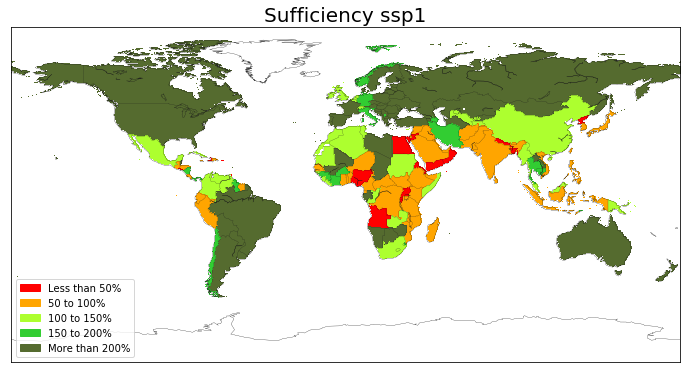

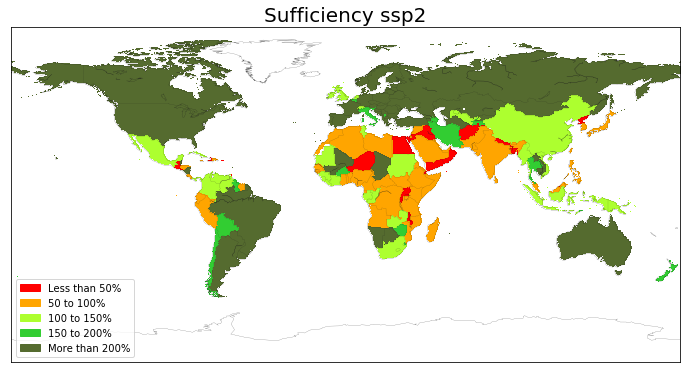

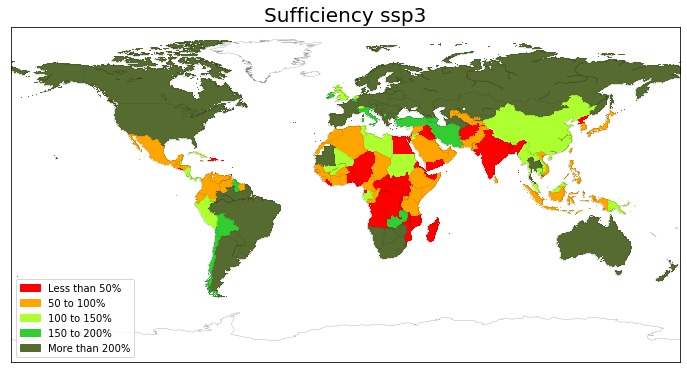

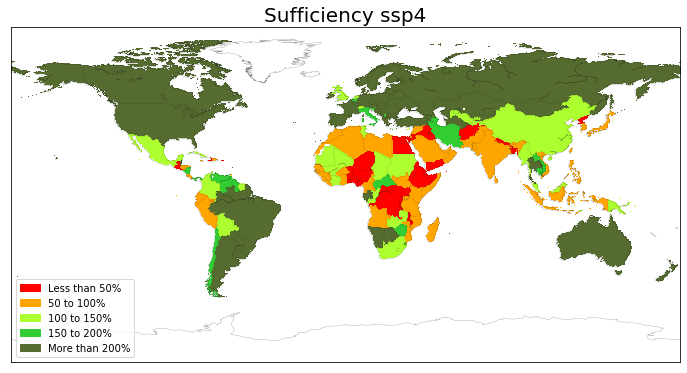

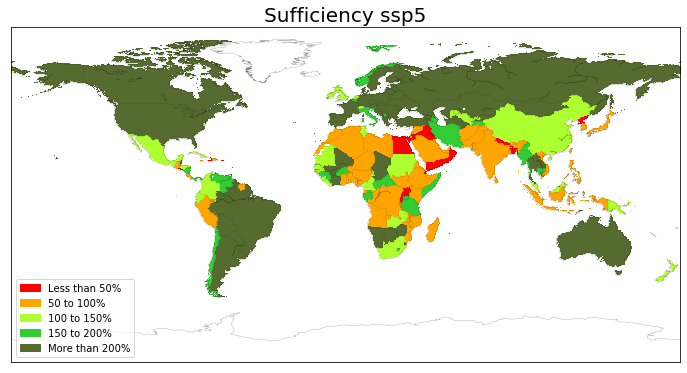

In [33]:
for ssp in climate_scenarios:
    print(ssp)
    fig, ax = plt.subplots(figsize=(12, 8))
    prod = pd.read_csv(os.path.join(compare_path, ssp+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
    suff_all = prod.join(sufficiencies.set_index('ISO3'), on='ISO3')
    
    if ssp == 'ssp1':
        title_2000 = 'Sufficiency 2000'
        suff_2000 = suff_all['2000']
        visualize_sufficiency(suff_2000*100, '2000', fig, ax, title_2000, savefig=True)

    title = 'Sufficiency ' + ssp
    suff = suff_all[ssp]
    visualize_sufficiency(suff*100, ssp, fig, ax, title, savefig=True)

ssp1


/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


ssp2
ssp3
ssp4
ssp5


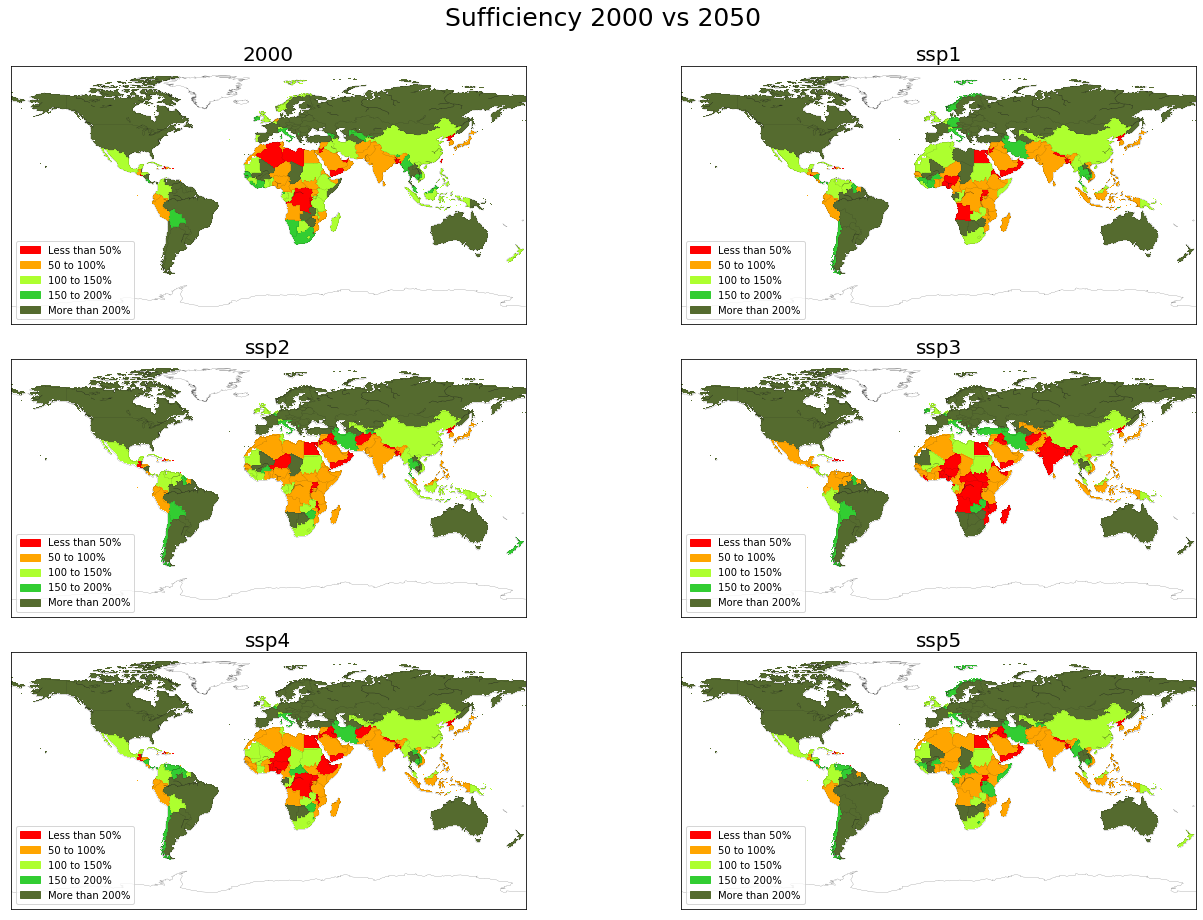

In [34]:
fig = plt.figure(figsize=(20, 13))
fig.suptitle('Sufficiency 2000 vs 2050', fontsize=25)

for i, ssp in enumerate(climate_scenarios): 
    print(ssp)
    prod = pd.read_csv(os.path.join(compare_path, ssp+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
    suff_all = prod.join(sufficiencies.set_index('ISO3'), on='ISO3')
    
    if ssp == 'ssp1':
        title_2000 = '2000'
        ax = plt.subplot(321)
        suff_2000 = suff_all['2000']
        visualize_sufficiency(suff_2000*100, ssp, fig, ax, title_2000, savefig=False)

    ax = plt.subplot(321 + i + 1)
    title = ssp
    suff = suff_all[ssp]
    visualize_sufficiency(suff*100, ssp, fig, ax, title, savefig=False)
    
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig(suff_fig_path + 'sufficiencies' + '.png', dpi=500)

## Aggregate sufficiencies

In [35]:
def visualize_sufficiency_all(suff, fig, ax, title, shape=(2160, 4320), savefig=False):
    suff_array = np.zeros((shape[0]*shape[1],)) - 1
    suff_array[suff.index] = suff['all_ssp'].values
    suff_df = pd.DataFrame(suff_array)
        
    c_list = ['green', 'red', 'pink', 'orange', '#0D98BA']
    cmap = colors.ListedColormap(c_list, name='my_colormap_name')
    cmap.set_under('w')
    
    legend = []
    legend.append(mpatches.Patch(color='red', label='Down in all'))
    legend.append(mpatches.Patch(color='orange', label='Down in most'))
    legend.append(mpatches.Patch(color='pink', label='Variable'))
    legend.append(mpatches.Patch(color='#0D98BA', label='Up in most'))
    legend.append(mpatches.Patch(color='green', label='Up in all'))
    
    #Plot data
    
    data = suff_df.values
    bm = Basemap()
    
    im = bm.imshow(np.flipud(data.reshape(shape)), vmin=0, cmap=cmap, ax=ax)
    
    bm.drawcoastlines(linewidth=0.15, color='0.1', ax=ax)
    bm.drawcountries(linewidth=0.1, color='0.1', ax=ax)
        
    ax.set_title(title, fontsize=20)
    plt.legend(handles=legend, loc=3)
  
    if savefig != False:
        fig.savefig(suff_fig_path + 'sufficiency_' + 'all_ssp' + '.png', dpi=500)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


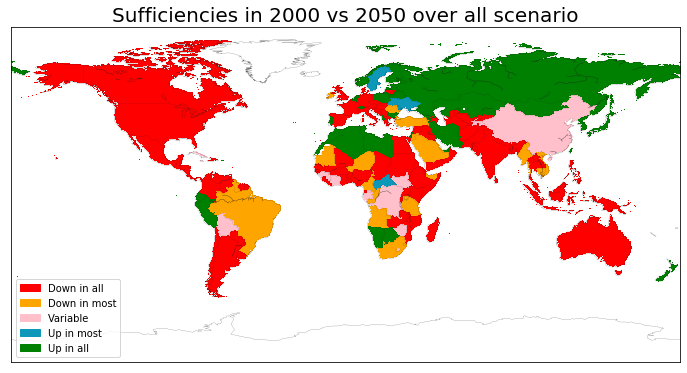

In [36]:
# Cases: 
#-1: no info

#0: up all scenario (Green)
#1: down all scenario (Red)

# in 2/3 scenarios
#2: variable (Pink)

# in 4 scenarios
#3: down most (Orange)
#4: up most (Blue-Green)


fig, ax = plt.subplots(figsize=(12, 8))

sufficiencies['all_ssp'] = -1
for i, country in sufficiencies.iterrows():
    state = -1
    val_2000 = country['2000']   
    down = 0
    up = 0
    num_nan = 0
    for ssp in climate_scenarios:
        if (country[ssp] == np.nan) or (val_2000 == np.nan):
            num_nan += 1
        # Case 1, 2 or 3
        elif country[ssp] - val_2000 < 0:
            down += 1
        # Case 0, 2 or 4
        elif country[ssp] - val_2000 >= 0:
            up += 1
    
    # Compare diff values
    # Case 
    if up == 5 - num_nan: state = 0
    elif down == 5 - num_nan: state = 1
    elif up == 4 - num_nan: state = 4
    elif down == 4 - num_nan: state = 3
    elif (down == 3 - num_nan) or (down == 2 - num_nan): state = 2
    
    sufficiencies.at[i, 'all_ssp'] = state
            

prod = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
suff_all = prod.join(sufficiencies.set_index('ISO3'), on='ISO3')

title = 'Sufficiencies in 2000 vs 2050 over all scenario'
visualize_sufficiency_all(suff_all, fig, ax, title, savefig=True)

In [37]:
def visualize_sufficiency_below(suff, fig, ax, title, shape=(2160, 4320), savefig=False):
    suff_array = np.zeros((shape[0]*shape[1],)) - 1
    suff_array[suff.index] = suff['get_below'].values
    suff_df = pd.DataFrame(suff_array)
        
    c_list = ['red', 'orange', 'gold', 'purple', 'violet', 'pink', 'beige']
    cmap = colors.ListedColormap(c_list, name='my_colormap_name')
    cmap.set_under('w')
    
    legend = []
    legend.append(mpatches.Patch(color='red', label='Gets below 1 in all'))
    legend.append(mpatches.Patch(color='orange', label='Gets below 1 in most'))
    legend.append(mpatches.Patch(color='gold', label='Gets below 1 in some'))
    legend.append(mpatches.Patch(color='purple', label='Was and is still below 1 in all'))
    legend.append(mpatches.Patch(color='violet', label='Was and is still below 1 in most'))
    legend.append(mpatches.Patch(color='pink', label='Was and is still below 1 in some'))
    
    
    #Plot data
    
    data = suff_df.values
    bm = Basemap()
    
    im = bm.imshow(np.flipud(data.reshape(shape)), vmin=0, cmap=cmap, ax=ax)
    
    bm.drawcoastlines(linewidth=0.15, color='0.1', ax=ax)
    bm.drawcountries(linewidth=0.1, color='0.1', ax=ax)
        
    ax.set_title(title, fontsize=20)
    plt.legend(handles=legend, loc=3)
  
    if savefig != False:
        fig.savefig(suff_fig_path + 'sufficiency_' + 'get_below_one' + '.png', dpi=500)

In [38]:
# Cases: 
#-1: no info
#0: all get bellow 1 (Red)
#1: most get bellow 1 (Orange)

#2: was belown 1 and still in all
#3: was belown 1 and still in most

#4: other  (Beige)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


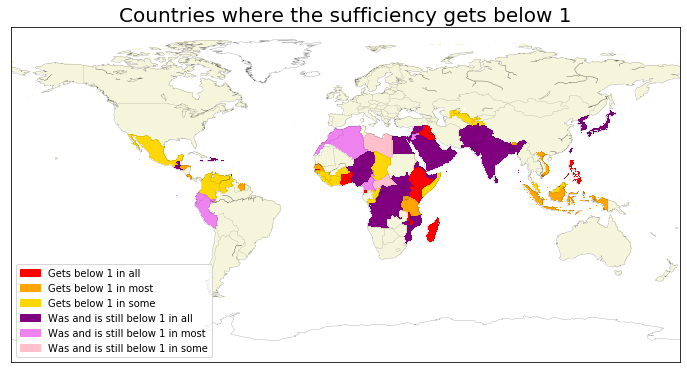

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))

sufficiencies['get_below'] = 6
for i, country in sufficiencies.iterrows():
    state = 6
    if country['2000'] >= 1: 
        start = 1
    else: 
        start = 0        
    diff = 0
    for ssp in climate_scenarios:
        if start == 1 and country[ssp] < 1:
            diff += 1
        elif start == 0 and country[ssp] > 1:
            diff += 1
    
    # Compare diff values
    # Case 
    if start == 1 and diff == 5: 
        state = 0
        
    elif start == 1 and diff == 4:
        state = 1
    
    elif start == 1 and diff > 0:
        state = 2
        
    elif start == 0 and diff == 0:
        state = 3
    
    elif start == 0 and diff == 1:
        state = 4
        
    elif start == 0 and diff < 5:
        state = 5
            
    
    sufficiencies.at[i, 'get_below'] = state
            

prod = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
suff_all = prod.join(sufficiencies.set_index('ISO3'), on='ISO3')

title = 'Countries where the sufficiency gets below 1'
visualize_sufficiency_below(suff_all, fig, ax, title, savefig=True)

In [40]:
sufficiencies[sufficiencies['ISO3'].str.startswith('M')]

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,all_ssp,get_below
94,MAR,0.511462,1.081820,0.883328,0.828717,0.850426,0.624719,0,4
95,MDA,2.888517,6.932901,6.150338,2.734554,7.217087,7.742899,4,6
96,MDG,1.106782,0.629035,0.572517,0.312999,0.561928,0.614039,1,0
97,MEX,1.435218,1.186834,1.268369,0.834653,1.376876,1.215398,1,2
98,MKD,2.935567,2.432774,2.462289,2.308155,2.418593,2.312985,1,6
99,MLI,4.502259,2.012000,2.197187,1.486313,1.023469,2.258724,1,6
100,MMR,1.620466,1.271879,1.148309,1.241509,1.191644,1.769826,3,6
101,MNE,3.693281,2.648200,2.421509,2.421904,2.423869,2.333431,1,6
102,MNG,5.247659,10.667547,12.744913,6.064427,10.597284,10.788507,0,6
103,MOZ,0.887487,0.587503,0.649156,0.407717,0.525732,0.691925,1,3


In [41]:
not_taken = sub(list(countries_list), sufficiencies['ISO3'].values)
dropped_c = countries[countries['ISO3'].isin(not_taken)][['ISO3', 'name']].drop_duplicates()['name'].values
dropped_c.sort()
dropped_c

NameError: name 'sub' is not defined

## Infos countries

India, Brazil, France, USA, China

population, sufficiency, production, cropland

In [52]:
sufficiencies = pd.read_csv(suff_path + 'country_sufficiencies.csv')
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5
0,AFG,0.712556,0.626821,0.552870,0.461577,0.434928,0.768718
1,AGO,0.591377,0.533173,0.675277,0.452472,0.660541,0.809068
2,ALB,2.329763,2.890045,2.767915,2.706274,2.857853,2.793105
3,ARE,0.417912,0.605372,0.605035,0.611123,0.624504,0.602500
4,ARG,7.931488,6.698259,7.628184,7.175024,7.065768,7.249937


In [36]:
countries = pd.read_csv(base_path + 'country_ids.csv')
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1')
countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name', 'sovereignt']],right_on='base_id',left_on='country_id',how='right')

pop_dir = pop_path
pop = pd.read_csv(os.path.join(pop_dir,'pop_2000.csv'))
pop = pop.merge(countries, right_on='pixel_id', left_on='pixel_id')
pop_bycountry_2000 = pop.groupby('ISO3')['gpw_population'].sum()

prod = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
prod_bycountry_2000 = prod.groupby('ISO3')['calories_2000'].sum() 

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [63]:
def get_changes(country):
    changes = pd.DataFrame(columns=['2000', 'change_ssp1', 'change_ssp2', 'change_ssp3', 'change_ssp4', 'change_ssp5'], 
                           index=['pop', 'suff', 'prod', 'crop(%)'])
    
    
    changes.at['suff', '2000'] = sufficiencies[sufficiencies['ISO3'] == country]['2000'].values[0]
    changes.at['pop', '2000'] = pop_bycountry_2000[country]
    changes.at['prod', '2000'] = prod_bycountry_2000[country]
    
    df = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
    df['cropland_2000'] = df['ha_per_pixel'] * df['%cropland_2000']
    changes.at['crop(%)', '2000'] = df.groupby('ISO3')['cropland_2000'].sum()[country]
    
    
    for ssp in climate_scenarios:
        name = 'change_' + ssp
        df = pd.read_csv(os.path.join(compare_path, ssp+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
        
        changes.at['suff', name] = (sufficiencies[sufficiencies['ISO3'] == country][ssp].values[0] - changes.at['suff', '2000']) / changes.at['suff', '2000']
        
        pop = pd.read_csv(os.path.join(pop_dir,'pop_' + ssp + '.csv'))
        pop = pop.merge(countries, right_on='pixel_id', left_on='pixel_id')
        pop_bycountry = pop.groupby('ISO3')['gpw_population'].sum()
        changes.at['pop', name] = (pop_bycountry[country] - changes.at['pop', '2000']) / changes.at['pop', '2000']
        
        prod_bycountry = df.groupby('ISO3')['calories_2050'].sum() 
        changes.at['prod', name] = (prod_bycountry[country] - changes.at['prod', '2000']) / changes.at['prod', '2000']
        
        df['cropland_2050'] = df['ha_per_pixel'] * df['%cropland_2050']
        changes.at['crop(%)', name] = (df.groupby('ISO3')['cropland_2050'].sum()[country] - changes.at['crop(%)', '2000']) / changes.at['crop(%)', '2000']
    
    return changes 

In [64]:
# India
print('India')
get_changes('IND')

India


,2000,change_ssp1,change_ssp2,change_ssp3,change_ssp4,change_ssp5
pop,1.03828e+09,0.273267,0.175448,1.11563,0.299037,0.269964
suff,0.653553,0.045498,0.144271,-0.238291,0.043816,0.145437
prod,1.1043e+18,0.301484,0.358178,0.454716,0.339789,0.470679
crop(%),2.18699e+08,-0.0517236,7.88868e-05,0.0626794,-0.0194453,0.0724131


In [65]:
# Brazil
print('Brazil')
get_changes('BRA')

Brazil


,2000,change_ssp1,change_ssp2,change_ssp3,change_ssp4,change_ssp5
pop,1.68511e+08,0.127831,0.127917,0.128668,0.128121,0.127831
suff,3.64748,0.0427307,0.11079,0.0711667,-0.00557358,0.302315
prod,1.00013e+18,0.24303,0.341857,0.304493,0.180426,0.606187
crop(%),2.00392e+08,0.0514303,0.133953,0.0994143,-0.00254422,0.356709


In [66]:
# France
print('France')
get_changes('FRA')

France


,2000,change_ssp1,change_ssp2,change_ssp3,change_ssp4,change_ssp5
pop,5.90026e+07,0.0683851,0.0686514,0.0771331,0.0709898,0.0734986
suff,5.40715,-0.316892,-0.299655,-0.238352,-0.319926,-0.334276
prod,5.18418e+17,-0.359497,-0.339437,-0.268054,-0.360576,-0.40102
crop(%),2.84785e+07,-0.0879993,-0.0342982,0.0674864,-0.0690931,-0.0542632


In [67]:
# USA
print('USA')
get_changes('USA')

USA


,2000,change_ssp1,change_ssp2,change_ssp3,change_ssp4,change_ssp5
pop,2.75032e+08,0.0963864,0.0963863,0.0964063,0.0963863,0.968284
suff,5.52503,-0.280393,-0.258127,-0.16411,-0.137063,-0.517209
prod,2.47476e+18,-0.216114,-0.189611,-0.0741521,-0.0184627,-0.197242
crop(%),1.89026e+08,-0.0871323,-0.0323887,0.0837837,0.162148,-0.0260027


In [68]:
# China
print('China')
get_changes('CHN')

China


,2000,change_ssp1,change_ssp2,change_ssp3,change_ssp4,change_ssp5
pop,1.25246e+09,0.0507877,0.0542715,0.0542755,0.0501957,0.0508146
suff,1.41497,0.0327156,0.141218,0.0176824,0.127328,0.168413
prod,2.88644e+18,-0.0808103,0.0620928,-0.0745808,0.0398189,0.0967482
crop(%),2.7464e+08,-0.158307,-0.0193483,-0.161715,-0.0355792,0.00453797
